In [237]:
%%capture
#%matplotlib inline
%matplotlib notebook

%load_ext autoreload
%autoreload 2

%reset -f

import os
import numpy as np
import pylab as plt

In [238]:
from matplotlib import rc

plt.rcParams.update({
    # Axes and grid
    'axes.unicode_minus'         : False,  # Use standard minus sign instead of Unicode minus
    'axes.formatter.use_mathtext': True,   # Use mathtext for axis tick labels (e.g., 1e3 as 10³)
    'axes.grid'                  : True,   # Show grid on all plots by default

    # Figure
    'figure.figsize'             : (8, 6),  # Set default figure size (width, height) in inches

    # Font
    'font.size'                  : 14,        # Set default font size
    'font.family'                : 'serif',   # Use serif font family
    'font.serif'                 : ['cmr10'], # Use Computer Modern Roman (LaTeX-style serif)

    # Text and mathtext
    'text.usetex'                : False,     # Do not use LaTeX for text rendering
    'mathtext.fontset'           : 'cm',      # Use Computer Modern for mathtext (LaTeX-style)
})


In [239]:
from twpazer.sreader import sidreader

In [240]:
def poly_fit(x, y, degree=2, num_points=1000):
    p = np.poly1d(np.polyfit(x, y, degree))
    x_fit = np.linspace(np.min(x), np.max(x), num_points)
    y_fit = p(x_fit)
    return x_fit, y_fit


def freq2impedance(f, z, ftarget=6e9):
    index = np.argmin(np.abs(f-ftarget))
    return f[index], z[index]
    
    
def impedance2width(w, Z, Ztarget=50):
    index = np.argmin(np.abs(Z-Ztarget)) 
    return w[index], Z[index]

In [241]:
def different_freqs(sid, freqs=[6e9, 8e9, 10e9]):
    
    data = {k: {} for k in freqs}
    
    for f in freqs:
        
        if 'Z' not in data[f]:
            data[f].update({'Z': list()})
            
        if 'w' not in data[f]:
            data[f].update({'w': list()})
                           
        for s in sid:
            f_fit, z_fit = poly_fit(s['pars']['freq'], s['pars']['Z0P1'], degree=3)
            ft, zt = freq2impedance(f_fit, z_fit, ftarget=f)
            data[f]['w'].append(s['w'])
            data[f]['Z'].append(zt)
                        
    
    return data

In [242]:
mainpath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-NIST/UltraHigh/transition/analysis'
filename = 'ustrip_Lk100pH_eps9.1_d150nm_merged.sid'


sid = sidreader(data=sidreader(os.path.join(mainpath,filename)).unique('merge'))
sid.compute('TL')

<IPython.core.display.Javascript object>


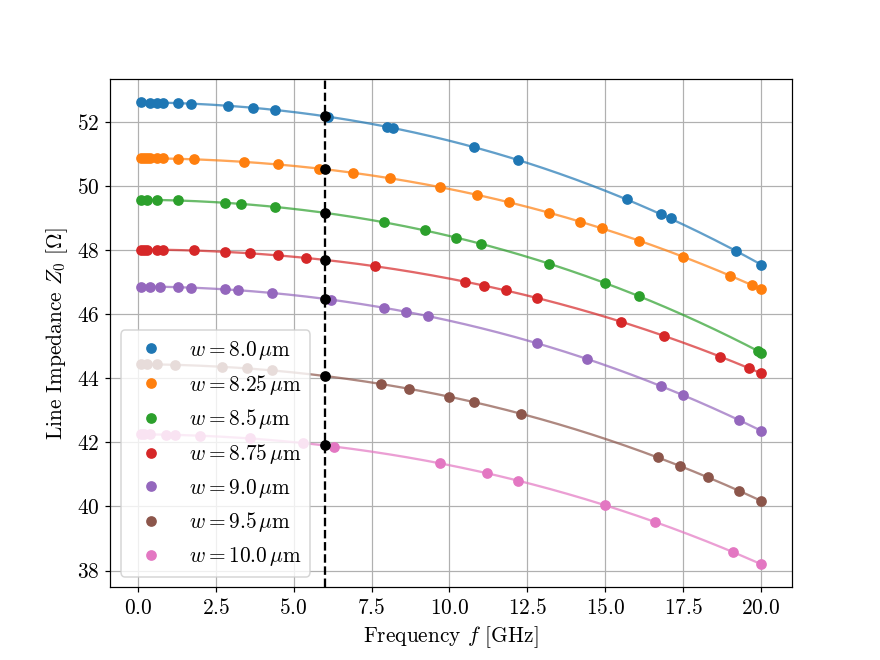

In [243]:
Z=list()
w=list()

plt.figure()

for s in sid:
    
    plt.plot(s['pars']['freq']/1e9, s['pars']['Z0P1'], marker = 'o', ls='none',            
             label='$w={w}\\,\\mu$m'.format(w=s['w']))
    
    f_fit, z_fit = poly_fit(s['pars']['freq'], s['pars']['Z0P1'], degree=3)

    # Plot the fitted curve
    plt.plot(f_fit/1e9, z_fit, alpha=0.7, color=plt.gca().lines[-1].get_color())
    
     
    ftarget=6e9
    ft, zt = freq2impedance(f_fit, z_fit, ftarget=ftarget)
    
    plt.plot(ft/1e9, zt, color = 'k', marker='o')
    
    Z.append(zt)
    w.append(s['w'])
    

plt.xlabel('Frequency $f$ [GHz]')
plt.ylabel('Line Impedance $Z_0$ [$\\Omega$]')
plt.legend(loc='best')
plt.axvline(x=ftarget/1e9, color='k', linestyle='--')

In [250]:
data=different_freqs(sid, freqs=[2e9, 4e9, 6e9, 8e9, 10e9, 12e9, 14e9, 16e9])

<IPython.core.display.Javascript object>


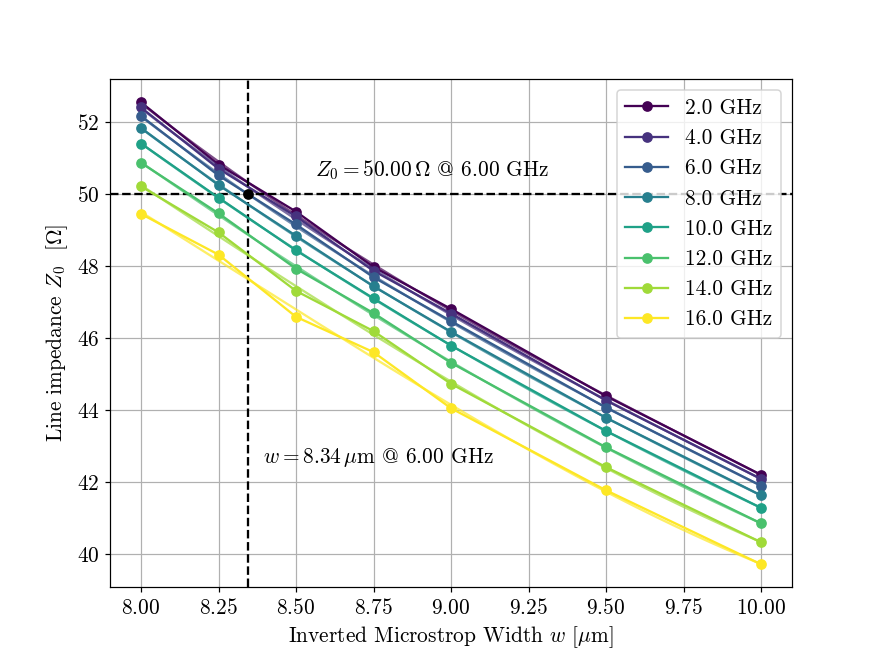

Z = 50.00 Ohm at w = 8.34 micron


In [251]:
plt.figure()
ftarget=6e9;
Ztarget=50

colors = plt.cm.viridis(np.linspace(0, 1, len(data)))

for i, f in enumerate(sorted(data)):
    plt.plot(data[f]['w'],data[f]['Z'], marker = 'o', color=colors[i], label=f"{f/1e9:.1f} GHz")
    w_fit, zz_fit = poly_fit(data[f]['w'], data[f]['Z'], degree=3)
    plt.plot(w_fit, zz_fit, alpha=0.7, color=plt.gca().lines[-1].get_color())
    
    data[f].update({'w_fit': w_fit,
                    'Z_fit': zz_fit})
    
    
    if f==ftarget:        
        wt, zzt = impedance2width(w_fit, zz_fit, Ztarget)
        plt.plot(wt, zzt, color = 'k', marker='o')
            
        plt.axvline(x=wt, color='k', linestyle='--')
        plt.axhline(y=zzt, color='k', linestyle='--')
    
        xtext=plt.xlim()[1]-0.70*(plt.xlim()[1]-plt.xlim()[0])    
        plt.text(xtext, zzt+0.5, '$Z_0 = {Z:.2f}\\,\\Omega$ @ {f:.2f} GHz'.format(Z=zzt, f=ftarget/1e9))
        
        ytext=plt.ylim()[1]-0.90*(plt.ylim()[1]-plt.ylim()[0])
        plt.text(wt+0.05, ytext, '$w = {w:.2f}\\,\\mu$m @ {f:.2f} GHz'.format(w=wt, f=ftarget/1e9))
        
        print(f"Z = {zzt:.2f} Ohm at w = {wt:.2f} micron")
        
        
#plt.ylabel('Line impedance $Z_0$ @ {f:.1f} GHz [$\\Omega$]'.format(f=ftarget/1e9))
plt.ylabel('Line impedance $Z_0$  [$\\Omega$]'.format(f=ftarget/1e9))
plt.xlabel('Inverted Microstrop Width $w$ [$\\mu$m]')
plt.legend(loc='best')


In [252]:
Zs = [data[f]['Z_fit'][np.argmin(np.abs(data[f]['w_fit'] - wt))] for f in data]

<IPython.core.display.Javascript object>


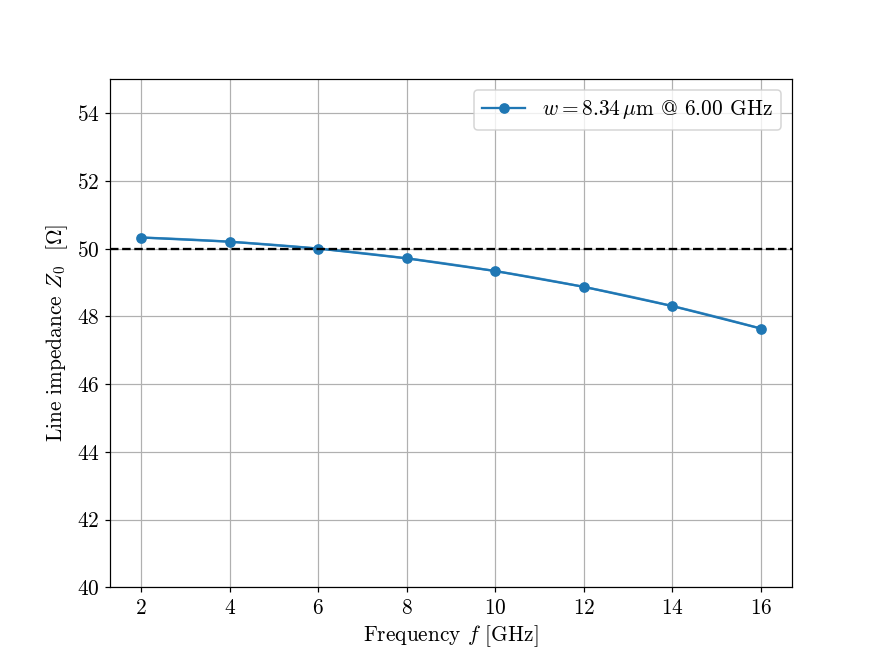

<IPython.core.display.Javascript object>


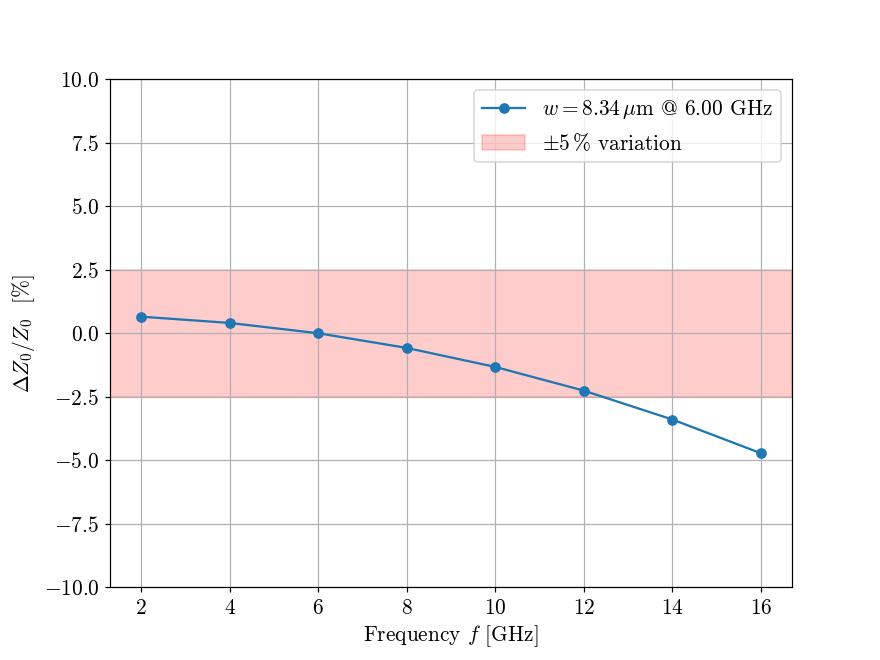

In [254]:
plt.figure()

fs=np.array(list(data.keys()))
plt.plot(fs/1e9,Zs, marker='o', 
         label='$w = {w:.2f}\\,\\mu$m @ {f:.2f} GHz'.format(w=wt, f=ftarget/1e9))
fs_fit, Zs_fit = poly_fit(fs, Zs, degree=3)
plt.plot(fs_fit/1e9, Zs_fit, alpha=0.7, color=plt.gca().lines[-1].get_color())

plt.axhline(y=50, color='k', linestyle='--')
plt.ylim([50-10, 50+5])

plt.ylabel('Line impedance $Z_0$  [$\\Omega$]'.format(f=ftarget/1e9))
plt.xlabel('Frequency $f$ [GHz]')

plt.legend(loc='best')



plt.figure()

dZ = (np.array(Zs)-Ztarget)/Ztarget*100

plt.plot(fs/1e9, dZ, marker='o', 
         label='$w = {w:.2f}\\,\\mu$m @ {f:.2f} GHz'.format(w=wt, f=ftarget/1e9))


plt.axhspan(-2.5, +2.5, alpha=0.2, color='red', label='$\pm 5\,\%$ variation')


#fs_fit, Zs_fit = poly_fit(fs, Zs, degree=3)
#plt.plot(fs_fit/1e9, Zs_fit, alpha=0.7, color=plt.gca().lines[-1].get_color())

#plt.axhline(y=50, color='k', linestyle='--')
plt.ylim([0-10, 0+10])

plt.ylabel('$\Delta Z_0/Z_0$  [$\\%$]'.format(f=ftarget/1e9))
plt.xlabel('Frequency $f$ [GHz]')

plt.legend(loc='best')